# Session 3

### Goals:

1. Generalize previous codebase to multiple data points
2. Introduce torch.nn Module
3. Introduce optimizers
4. Train a linear classifier
5. Train a FFNN

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from IPython import display

import seaborn as sns
import torch

In [2]:
# Always set a seed in your file
torch.manual_seed(42)

In [3]:
# Ignore these functions. They're here only to help with visualization.
if True:

    def viz_1d(X, Y, title = None):
        
        if isinstance(Y, torch.Tensor):
            Y = Y.detach()
            
        plt.figure(figsize=(14, 10))
        if title:
            plt.title(title)
        plt.scatter(X, Y)
        plt.show()

    def viz_pred(X, Y, Y_, title=None):
        
        if isinstance(Y_, torch.Tensor):
            Y_ = Y_.detach()
            
        plt.figure(figsize=(14, 10))
        if title:
            plt.title(title)
            
        plt.plot(X, Y, 'o')
        plt.plot(X, Y_, '+')
    #     plt.scatter(X, Y, color='red')
        plt.show()
        
    def viz_all(model, inputs,outputs= None, predictions= None,  ax=None ):
        inputs_scale = (inputs.max()-inputs.min())/10.0
        _X = torch.tensor(np.mgrid[inputs.min()-inputs_scale: inputs.max()+inputs_scale:0.1], dtype=torch.float32)
        _X = _X.reshape(-1,1)
        with torch.no_grad():
            _Y = model(_X).detach()
            
        if ax is None: 
            fig = plt.figure(figsize=(14, 8), dpi=100)
            ax = fig.add_subplot(111)
            old_ax = False
        else:
            old_ax = True
        
        if outputs is not None:
            ax.scatter(inputs, outputs,  c='b', marker="s", label='Y Gold')
        
        if predictions is not None:
            ax.scatter(inputs, predictions, c='r', marker='+', label='Y Pred')
        
        ax.plot(_X, _Y, label='model')
        if not old_ax:
            plt.legend(loc='upper left')
            plt.show()
    

# Problem Definition

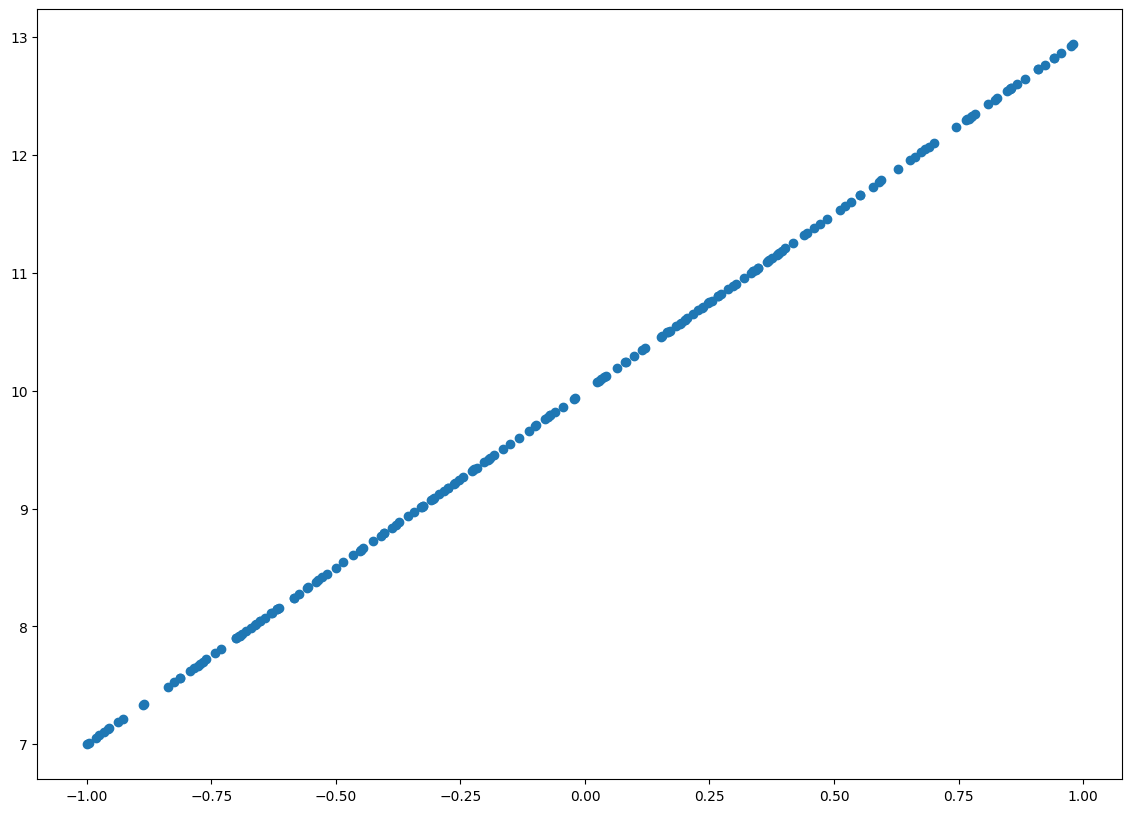

In [4]:
# Write a function to generate raw data
def true_fn(x: torch.Tensor |  float) -> float:
    """Returns a linear transformation over the tensor: 3x+10"""
    return float(3*x + 10)

# Set a particular size of dataset (under 1k is good; 200 for now)
n_samples = 200

# Generate input samples
X = torch.randint(-2*n_samples, 2*n_samples, (n_samples,)).float() / (2*n_samples)
Y = [true_fn(x) for x in X]
Y = torch.tensor(Y,dtype=torch.float32)
fx = lambda x : (m*x) + c
viz_1d(X, Y)

# Solution Definition

In [5]:
# How we did it in the past

# the lambda/regular function def
m = torch.tensor(0.5, requires_grad=True)
c = torch.tensor(0.1, requires_grad=True)
fx = lambda x: (m*x) + c

fx(10)

tensor(5.1000, grad_fn=<AddBackward0>)

In [6]:
# How should we do it in the future
class LinearRegressor(torch.nn.Module):

    def __init__(self: "LinearRegressor"):
        super().__init__()

        self.linear_layer = torch.nn.Linear(1,1) # bias=True; is default
    
    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(inputs)

In [7]:
# Make model
m = LinearRegressor()

In [8]:
# See model parameters
list(m.named_parameters())

[('linear_layer.weight',
  Parameter containing:
  tensor([[-0.9083]], requires_grad=True)),
 ('linear_layer.bias',
  Parameter containing:
  tensor([-0.3690], requires_grad=True))]

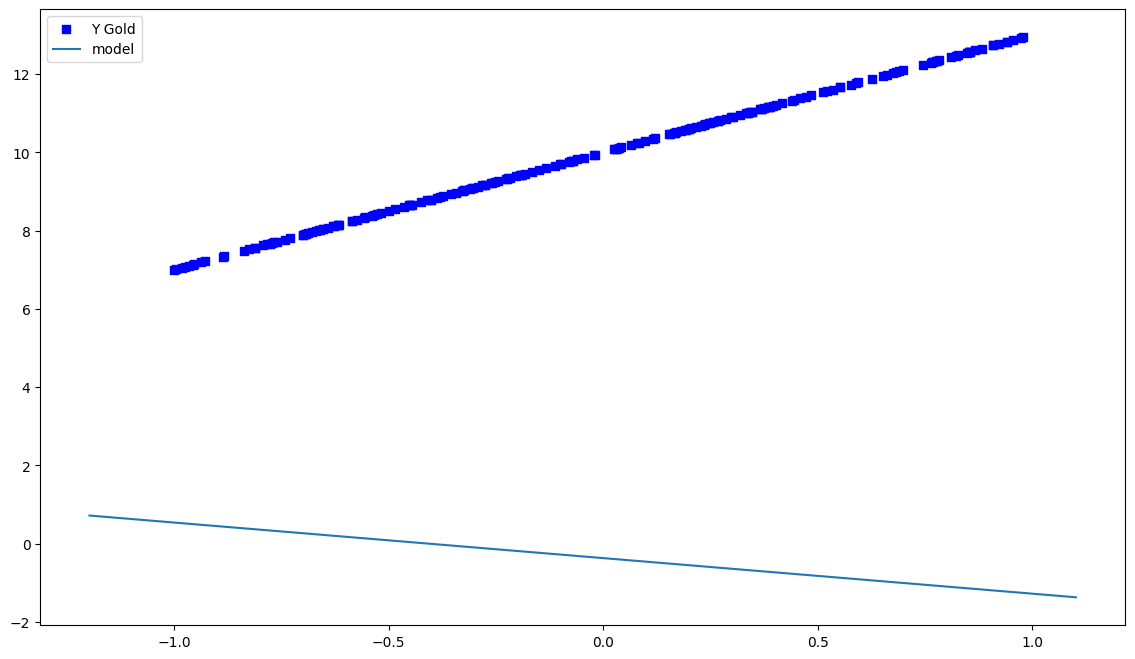

In [10]:
# See what the model looks like
viz_all(m, X, Y)

In [11]:
# How do we use the model?
# Which of these should work?
q = torch.tensor(4)
q = torch.randn(4,)
q = torch.randn(4,1)
q = torch.randn(4,4,1)
q = torch.randn(10, 1)
q = 10
q = np.random.randn(10, 1)
q = torch.randint(1, 10, (5, 1))
q = torch.randn(5,3,5,2,4,1)
m(q).shape, q.shape

(torch.Size([5, 3, 5, 2, 4, 1]), torch.Size([5, 3, 5, 2, 4, 1]))

In [ ]:
# Q: Can we implement it without using 'layers'?
class LinearRegressor(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.m = torch.nn.Parameter(torch.tensor(0.5))
        self.c = torch.nn.Parameter(torch.tensor(0.1))

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return (self.m * inputs) + self.c
    
list(LinearRegressor().named_parameters())

#### Why model class?

- Saving/Loading from Disk
- Setting training mode/evaluation mode
- Easy access to all parameters
- Structure is v. important for complex models
- That is 'pytorch' way!

# Let's train it now

We need three things:

1. The model itself
2. The loss function of choice
3. A way to update the parameters after computing the loss

In [34]:
#  Loss fn, as before
lfn = torch.nn.MSELoss(reduction='sum')

In [ ]:
# Make optimizer instead of updating parameters on our own
opt = torch.optim.SGD(m.parameters(), lr=0.01)

In [20]:
# See optimizer things (param groups)
opt.param_groups

[{'params': [Parameter containing:
   tensor([[3.0221]], requires_grad=True),
   Parameter containing:
   tensor([8.0181], requires_grad=True)],
  'lr': 0.01,
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'differentiable': False,
  'fused': None}]

In [25]:
# All the constituents of our 'algorithm'
m, lfn, opt

(LinearRegressor(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 MSELoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [22]:
# For how many iterations should we run our loop?
epochs = 2000

Model fully converged. Stopping.


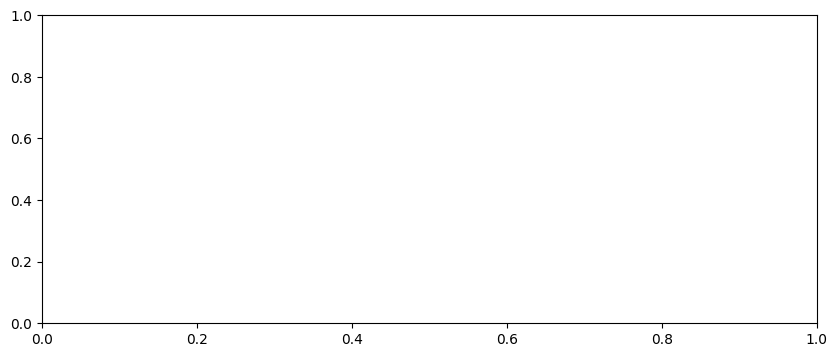

In [23]:

fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(111)
# xlim = (-1,2, 1.2)
# ylim = (-1, 14)
# ax1.set_xlim(-1.2, 1.2)
# ax1.set_ylim(-1, 14)
losses = []

# our dataset = X, Y

for e in range(epochs):

    opt.zero_grad() 
    
    # Lets sample a batch
    Xrange = torch.randint(0, n_samples, (20, 1
                                          ))
    _X = X[Xrange]
    _Y = Y[Xrange]
    
    # Make model predictions
    Y_pred = m(_X)
    
    # Calculate Loss
    loss = lfn(Y_pred, _Y)
    
    print(f"Parameterres before update:\n\tm: {m.linear_layer.weight.item()}\tgrad: {m.linear_layer.weight.grad.item() if m.linear_layer.weight.grad else None}\n\ta2: {m.linear_layer.bias.item()}\tgrad: {m.linear_layer.bias.grad.item() if m.linear_layer.bias.grad else None}")

    # Backpropagate
    loss.backward()
    
    # Update Parameters (m = m - lr*(dL/dm))
    opt.step()
    
    print(f"Parameters before update:\n\tm: {m.linear_layer.weight.item()}\tgrad: {m.linear_layer.weight.grad.item() if m.linear_layer.weight.grad else None}\n\ta2: {m.linear_layer.bias.item()}\tgrad: {m.linear_layer.bias.grad.item() if m.linear_layer.bias.grad else None}")
    with torch.no_grad():
        ...
        print(loss.item())
#         ax1.set_xlim(xlim[0], xlim[1])
#         ax1.set_ylim(ylim[0], ylim[1])
        viz_all(model=m, inputs=_X, outputs=_Y, ax=ax1)
#         viz_all(model=m, inputs=_X, outputs=_Y)
        display.display(plt.gcf())

    cmd = input('$: ')
    if cmd.lower().strip() in ['quit', 'q', 'exit', 'stop']:
        break

    plt.cla()
    display.clear_output(wait =True)
    losses.append(loss.item())
        
    if loss.item() < 0.001:
        print('Model fully converged. Stopping.')
#         viz_all(model=m, inputs=X, outputs=Y)
        break

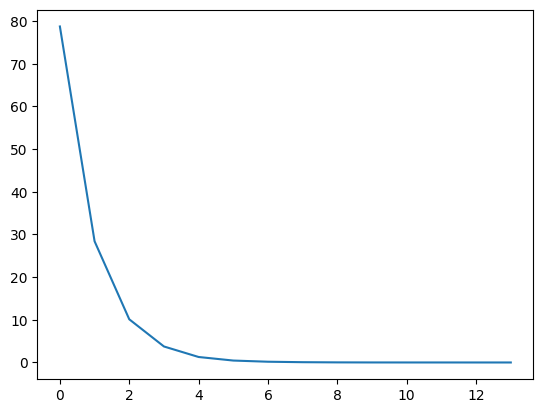

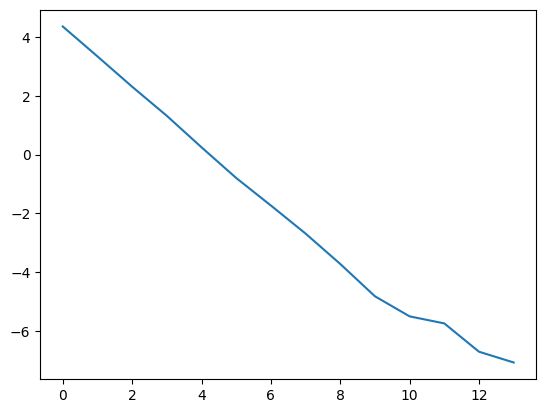

In [24]:
plt.plot(losses)
plt.show()
plt.plot(torch.log(torch.tensor(losses)))
plt.show()
